# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [22]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [5]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [7]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [8]:
# create dataframe of customer responses
responses = pd.pivot_table(df_transactions, values='n', index='customer_name', columns='offer_id', fill_value=0)
responses.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

## Answers:
#### The values of SS that represent better clusterings are generally smaller values of SS. This is because it means that this would minimize the distance between points in a cluster and the centroid. There is a point of diminishing return, however. In theory if k=n where n is the total number of points then SS would become 0 because each point would be it's own mean and the error for each cluster would be zero

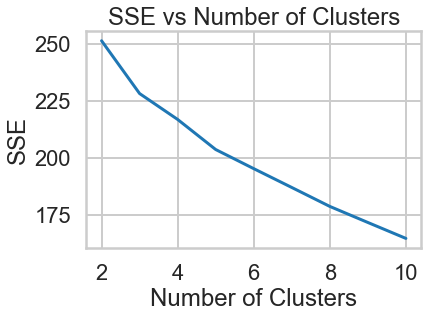

In [9]:
# create numpy array of responses
x_cols = responses.to_numpy()

# define range of k clusters to cover
ks = range(2, 11)
# initialize empty score list
scores=[]

# loop through all ks
for k in ks:
    # make KMeans instance
    kmeans = KMeans(n_clusters=k, random_state=42)
    # fit model to array
    kmeans.fit(x_cols)
    # calculate sum-of-squares error for k clusters and append to scores
    scores.append(kmeans.inertia_)

# plot SSE vs k clusters
plt.plot(ks, scores)
# add title and axis labels
plt.title('SSE vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

#### The elbow is not very clear in this case but appears to be either 3 or 5. Let's pick 3 and see what we learn.

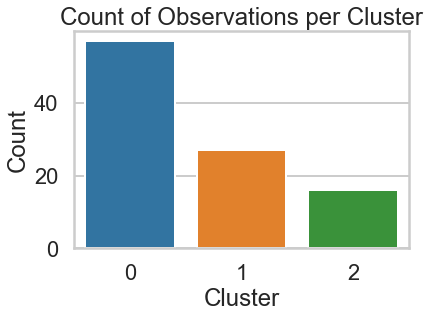

In [10]:
best_k = 3
# make KMeans instance
kmeans = KMeans(n_clusters=3, random_state=42)
# fit model to array
kmeans.fit(x_cols)

# make countplot of the labels assigned to each observation
sns.countplot(kmeans.labels_)
# add title and axis labels
plt.title('Count of Observations per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

#### The biggest challenge with using the elbow method for this example was the subjectivity of selecting the elbow. In this case, the elbow was not obvious so it made selection particularly difficult.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

## Answers:

For n_clusters = 2 The average silhouette_score is : 0.09365573283492713
For n_clusters = 3 The average silhouette_score is : 0.11889942863638556
For n_clusters = 4 The average silhouette_score is : 0.12347053919571699
For n_clusters = 5 The average silhouette_score is : 0.14092516241984757
For n_clusters = 6 The average silhouette_score is : 0.1371798939109807
For n_clusters = 7 The average silhouette_score is : 0.1161092456616906
For n_clusters = 8 The average silhouette_score is : 0.11339573832632867
For n_clusters = 9 The average silhouette_score is : 0.12505960527779877
For n_clusters = 10 The average silhouette_score is : 0.11928332134753233


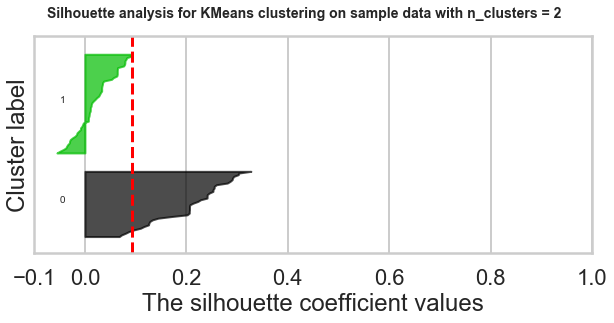

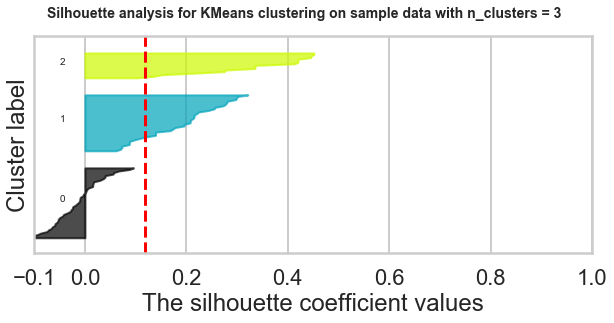

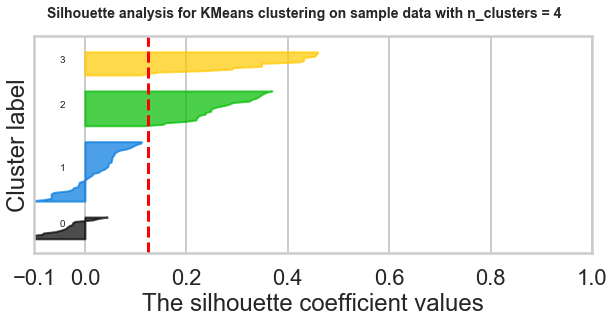

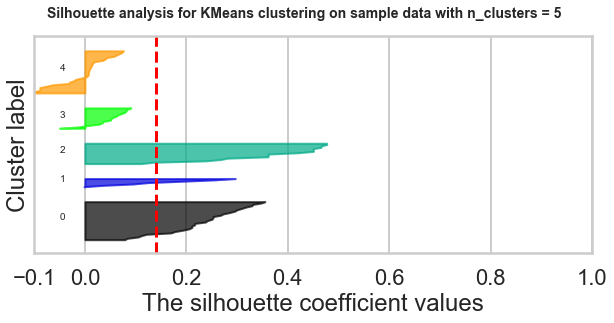

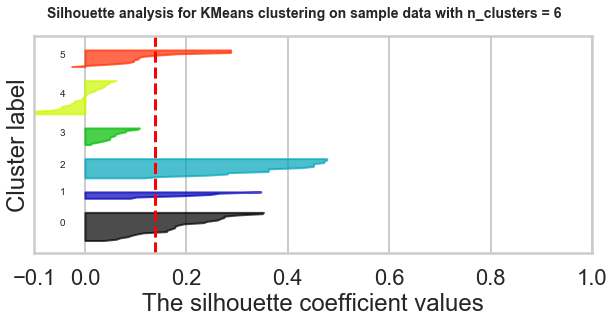

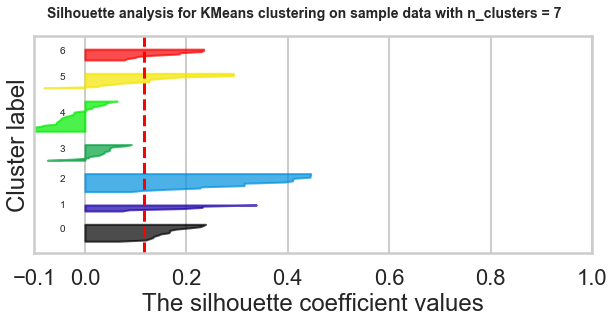

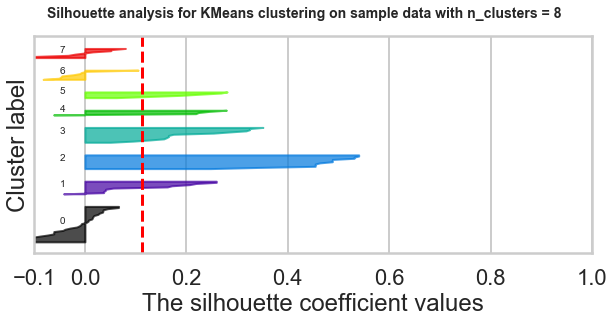

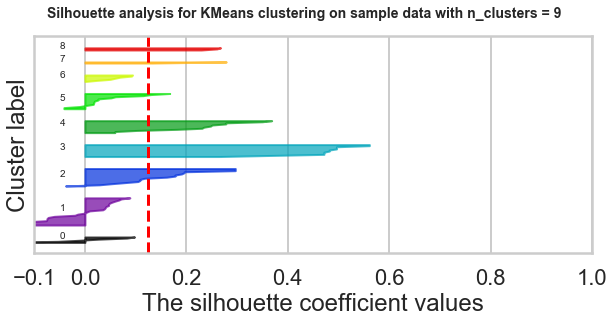

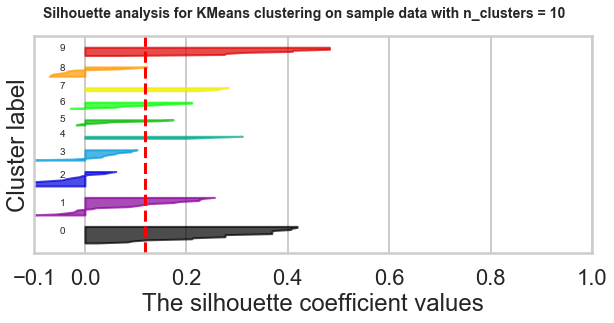

In [11]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X = x_cols

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
sil_scores = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    sil_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),
             fontsize=14, fontweight='bold')


plt.show()

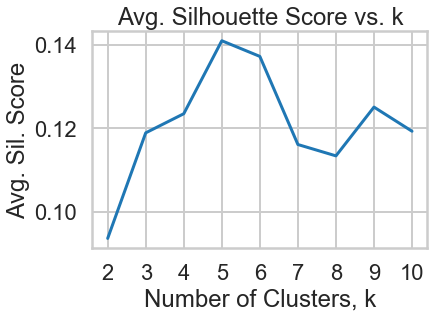

In [12]:
# create plot of average silhoutte scores vs number of clusters
plt.plot(ks ,sil_scores)
# set x ticks
plt.xticks(ks)
# set title and x y labels
plt.title('Avg. Silhouette Score vs. k')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Avg. Sil. Score')
plt.show()

The silhouette method suggests we should pick k=5 which was the higher range of potential k's which I suggested using the elbow method. 

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

## Answers:

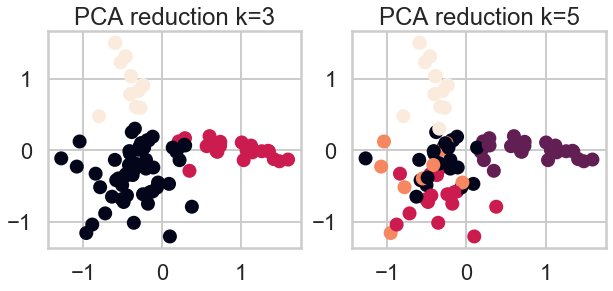

In [13]:
# make KMeans instance
kmeans3 = KMeans(n_clusters=3, random_state=42)
kmeans5 = KMeans(n_clusters=5, random_state=42)
# fit model to array
kmeans3.fit(x_cols)
kmeans5.fit(x_cols)

# create PCA instance with 2 components
reduction = PCA(n_components=2)
# fit to data and transform
reduced_x = reduction.fit_transform(x_cols)

red_xy = pd.DataFrame(reduced_x, columns=['x', 'y'])
red_xy['labels3'] = kmeans3.labels_
red_xy['labels5'] = kmeans5.labels_
red_xy['customers'] = responses.index

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 4)

ax1.scatter(red_xy.x, red_xy.y, c=red_xy.labels3)
ax1.set_title('PCA reduction k=3')
ax2.scatter(red_xy.x, red_xy.y, c=red_xy.labels5)
ax2.set_title('PCA reduction k=5')
plt.show()

#### Based on the PCA reduction plot i would suggest that k=3 is a better solution that k=5. With k=5 there is a lot of overlap between 3 of the clusters that lacks clarity. In either case there are very clearly two clusters that move out from the main group in a roughly linear fashion.

In [265]:
labeled_df = df_transactions.merge(red_xy, left_on='customer_name', right_on='customers')
labeled_df = labeled_df.merge(df_offers, on='offer_id')
labeled_df = labeled_df.drop(['n', 'x', 'y', 'customers'], axis=1)
labeled_df.head()

,customer_name,offer_id,labels3,labels5,db_labels,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,2,4,2,January,Pinot Noir,72,17,France,False
1,Rodriguez,2,2,4,2,January,Pinot Noir,72,17,France,False
2,Martin,2,0,0,0,January,Pinot Noir,72,17,France,False
3,Jackson,2,0,2,0,January,Pinot Noir,72,17,France,False
4,Campbell,2,2,4,2,January,Pinot Noir,72,17,France,False


#### Let's check the value counts for some suspected key features grouped by labels to see if we spot any trends.

In [252]:
# check value counts by group for varietal
labeled_df.groupby('labels3')['varietal'].value_counts()

labels3  varietal          
0        Champagne             79
         Cabernet Sauvignon    31
         Prosecco              27
         Espumante             15
         Malbec                15
         Chardonnay            14
         Merlot                13
         Pinot Noir             7
         Pinot Grigio           1
1        Espumante             25
         Malbec                16
         Pinot Grigio          16
         Prosecco              14
         Merlot                 6
         Cabernet Sauvignon     1
         Champagne              1
2        Pinot Noir            37
         Prosecco               2
         Champagne              1
         Chardonnay             1
         Malbec                 1
         Merlot                 1
Name: varietal, dtype: int64

#### In terms of varietal it seems that Group 0 has a strong preference for champagne, Group 1 has a marginal prefereance for Espumante and Group 2 has an extremely strong preference to Pinot Noir. For Group 2, it seems the preference for Pinot Noir is so strong that this may be the most important factor for Group 2.

In [17]:
# check value counts by group for min quantity
labeled_df.groupby('labels3')['min_qty'].value_counts()

labels3  min_qty
0        72         122
         144         44
         6           23
         12          13
1        6           75
         12           2
         72           1
         144          1
2        144         13
         6           12
         72          11
         12           7
Name: min_qty, dtype: int64

#### Group 0 tents to purchase larger minimum quantities with 72 topping the chart. Group 1 seems to prefer smaller minimum quantities with min quantity of 6 showing a strong lead. Group 2 does not seem to care about quantity.

In [18]:
# check value counts by group for origin
labeled_df.groupby('labels3')['origin'].value_counts()

labels3  origin      
0        France          88
         Chile           30
         Australia       14
         Oregon          13
         California      12
         Italy           12
         New Zealand     12
         South Africa    12
         Germany          9
1        France          33
         Oregon          13
         Australia       12
         South Africa    12
         Chile            7
         California       2
2        Australia       13
         Italy           12
         France           7
         Germany          7
         California       2
         New Zealand      1
         South Africa     1
Name: origin, dtype: int64

#### If we take a look at the value counts when grouping by origin, we see that groups 0 and 1 have a preference for French wine. Group 2 does not seem heavily biased by region showing only a slight preference for Australian and Italian wine.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

## Answers:

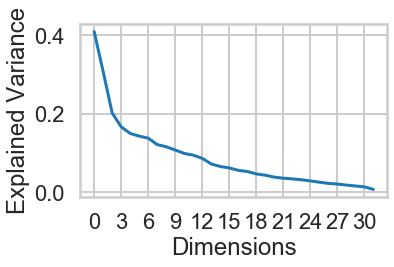

In [205]:
# Initialize a new PCA model with a default number of components.
pca = sklearn.decomposition.PCA()
pca.fit(X)

# plot the explained variance
plt.plot(pca.explained_variance_)
plt.xticks(range(0, 33, 3))
plt.ylabel('Explained Variance')
plt.xlabel('Dimensions')
plt.tight_layout()
plt.show()

#### The elbow point occurs right around x=3 suggesting that the optimal number of dimensions is 3.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


## Answers:

In [291]:
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

AProp = AffinityPropagation().fit(x_cols)
n_clusters_ = len(AProp.cluster_centers_indices_)
print('Affinity Propagation')
print('Number of Clusters: %d' % n_clusters_)
print('Silhouette Coefficient: %0.3f \n'
      % metrics.silhouette_score(x_cols, AProp.labels_, metric='sqeuclidean'))

# randomness causes large variations...
n_clusters = 3
SpecClust = SpectralClustering(n_clusters=n_clusters, assign_labels='discretize').fit(x_cols)
print('Spectral Clustering')
print('Number of Clusters: %d' % n_clusters)
print('Silhouette Coefficient: %0.3f \n'
      % metrics.silhouette_score(x_cols, SpecClust.labels_, metric='sqeuclidean'))

AggClust = AgglomerativeClustering(n_clusters=5).fit(x_cols)
print('Agglomerative Clustering')
print('Number of Clusters: %d' % AggClust.n_clusters_)
print('Silhouette Coefficient: %0.3f \n'
      % metrics.silhouette_score(x_cols, AggClust.labels_, metric='sqeuclidean'))

dbscan = DBSCAN(eps=1.4, min_samples=3).fit(x_cols)
dbscan_labels = dbscan.labels_
db_n_clusters_ = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
db_n_noise_ = list(dbscan_labels).count(-1)
print('DBSCAN')
print('Number of Clusters: %d' % db_n_clusters_)
print('Number of Noise Points: %d' % db_n_noise_)
print('Silhouette Coefficient: %0.3f \n'
      % metrics.silhouette_score(x_cols, dbscan.labels_, metric='sqeuclidean'))

Affinity Propagation
Number of Clusters: 14
Silhouette Coefficient: 0.180 

Spectral Clustering
Number of Clusters: 3
Silhouette Coefficient: 0.170 

Agglomerative Clustering
Number of Clusters: 5
Silhouette Coefficient: 0.219 

DBSCAN
Number of Clusters: 4
Number of Noise Points: 51
Silhouette Coefficient: 0.029 



#### In comparing the performance of various clustering algorithms I opted to utilize the silhouette coefficient because the data were not previously labeled to enable comparisons for prediction accuracy. The algorithms compared are affinity propagation, spectral clustering, agglomerative clustering, and DBSCAN. Both affinity propagation and spectral clustering hielded better silhouette scores than the previously used kmeans with k=5. The affinity propagation model, however, selected 14 clusters which is not as helpful when trying to tell a story to to sales/marketing. 

#### The agglomerative clustering performed the best yielding a silhouette coefficient of 0.219 with 5 clusters. This appears to be the best option of these 4 algorithms because it not only yields the best score but the clustering result corresponds well to the optimal k value we found early when evaluating kmeans.

#### DBSCAN struggled with this dataset. With an epsilon of 1.4 and minimum samples set to 4, the silhouette coefficient was only 0.035 suggesting a large amount of overlap between the clusters and not much clarity. Furthermore, these hyperparameters classified 51 points as noise which is about half of the data. I tried tuning these a bit and found that an epsilon of 1.5 only found one cluster and classified the remaining 35 points as noise and improved the silhouette score to .201. Comparing the labels to the offer details did not yield more compelling insights than what was previously done with kmeans, so it does not suggest the clustering is particularly insightful.

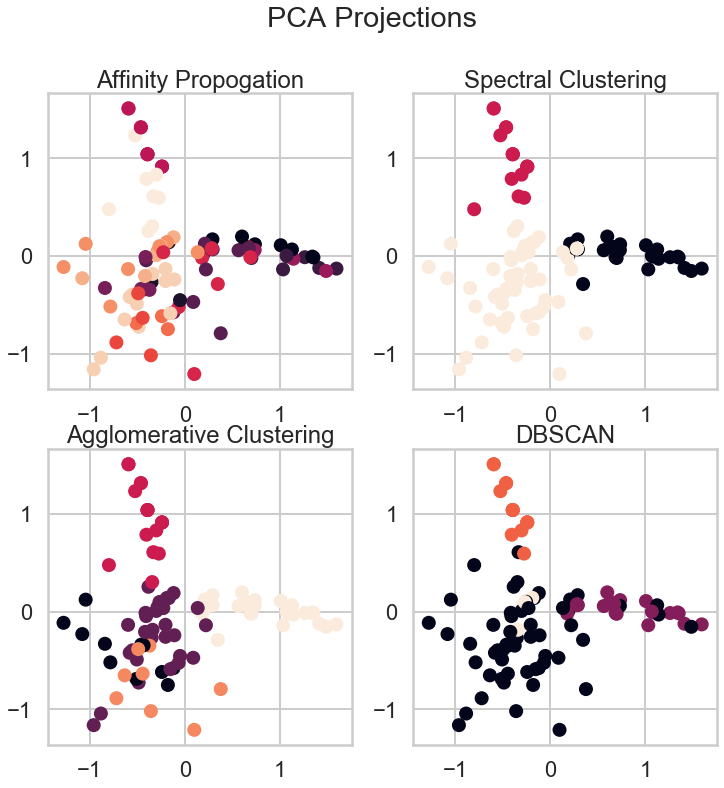

In [259]:
# create PCA instance with 2 components
reduction = PCA(n_components=2)
# fit to data and transform
reduced = db_reduction.fit_transform(x_cols)

reduced_df = pd.DataFrame(reduced, columns=['x', 'y'])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(12, 12)

fig.suptitle('PCA Projections')
ax1.scatter(reduced_df.x, reduced_df.y, c=AProp.labels_)
ax1.set_title('Affinity Propogation')
ax2.scatter(reduced_df.x, reduced_df.y, c=SpecClust.labels_)
ax2.set_title('Spectral Clustering')
ax3.scatter(reduced_df.x, reduced_df.y, c=AggClust.labels_)
ax3.set_title('Agglomerative Clustering')
ax4.scatter(reduced_df.x, reduced_df.y, c=dbscan.labels_)
ax4.set_title('DBSCAN')
plt.show()

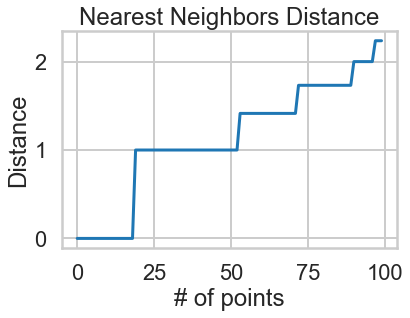

In [276]:
from sklearn.neighbors import NearestNeighbors
# create a neighbor object between 2 adjacent neighbors
neigh = NearestNeighbors(n_neighbors=2)
# fit the dataset to this object finding the distances between each pair of points
nbrs = neigh.fit(x_cols)
# unpack the distances
distances, indices = nbrs.kneighbors(x_cols)

# sort the distances in ascending order
distances = np.sort(distances, axis=0)
# extract the distance values
distances = distances[:,1]
# plot the nearest neighbors distances
plt.plot(distances)
plt.title('Nearest Neighbors Distance')
plt.ylabel('Distance')
plt.xlabel('# of points')
plt.show()